In [1]:
import os, math
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

def open_da(path, engine_order=("netcdf4","h5netcdf","scipy")):
    last_err = None
    for eng in engine_order:
        try:
            ds = xr.open_dataset(path, engine=eng)
            break
        except Exception as e:
            last_err = e
    else:
        raise last_err
    # pick first 2D/3D var
    var = next(v for v in ds.data_vars if ds[v].ndim >= 2)
    da = ds[var]
    # normalize missing
    fv = da.attrs.get("_FillValue", None)
    if fv is not None:
        da = da.where(da != fv)
    # orientation: north up
    lat_name = "lat" if "lat" in da.coords else "latitude"
    da = da.sortby(lat_name)
    return da, var, lat_name

def describe_da(da, name):
    tlen = int(da.sizes.get("time", 0))
    lat_name = "lat" if "lat" in da.coords else "latitude"
    lon_name = "lon" if "lon" in da.coords else "longitude"
    print(f"\n{name}: dims={dict(da.sizes)}, units={da.attrs.get('units','?')}")
    print(f"  time steps: {tlen}, lat in [{float(da[lat_name].min()):.2f},{float(da[lat_name].max()):.2f}] "
          f"lon in [{float(da[lon_name].min()):.2f},{float(da[lon_name].max()):.2f}]")
    # quick stats on first frame
    v0 = da.isel(time=0)
    nans = int(np.isnan(v0.values).sum())
    print(f"  sample0: min={np.nanmin(v0.values):.4g} max={np.nanmax(v0.values):.4g} NaNs={nans}")

def panel_4samples(da, title, cmap=None, yincrease=True, vmin=None, vmax=None, samples=(0,6,12,18)):
    # global vmin/vmax for fair comparison (compute from whole year if not given)
    if vmin is None or vmax is None:
        vmin = float(da.min())
        vmax = float(da.max())
    ncols = 4
    nrows = 1
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, 3.4), constrained_layout=True)
    if ncols == 1:
        axes = [axes]
    for i, samp in enumerate(samples):
        ax = axes[i]
        img = da.isel(time=samp).plot(ax=ax, add_colorbar=False, cmap=cmap, vmin=vmin, vmax=vmax, yincrease=yincrease)
        ax.set_title(f"sample {samp}", fontsize=10)
        ax.set_xlabel(""); ax.set_ylabel("")
    cbar = fig.colorbar(img, ax=axes, shrink=0.85)
    cbar.set_label(da.name if da.name else "")
    plt.suptitle(title, y=1.02)
    plt.show()

In [2]:
ssrd_path = "/ptmp/mp002/ellis/lai/ssrd/ssrd.15daily.fc.era5.1440.720.1979.nc"
t2m_path  = "/ptmp/mp002/ellis/lai/t2m/t2m.15daily.an.era5.1440.720.1979.nc"
tp_path   = "/ptmp/mp002/ellis/lai/tp/tp.15daily.fc.era5.1440.720.1979.nc"

ssrd, ssrd_name, _ = open_da(ssrd_path)
t2m,  t2m_name,  _ = open_da(t2m_path)
tp,   tp_name,   _ = open_da(tp_path)

# quick prints
describe_da(ssrd, ssrd_name)
describe_da(t2m,  t2m_name)
describe_da(tp,   tp_name)


ssrd: dims={'time': 24, 'latitude': 720, 'longitude': 1440}, units=MJ m2
  time steps: 24, lat in [-89.88,89.88] lon in [-179.88,179.88]
  sample0: min=0 max=38.44 NaNs=0

t2m: dims={'time': 24, 'latitude': 720, 'longitude': 1440}, units=K
  time steps: 24, lat in [-89.88,89.88] lon in [-179.88,179.88]
  sample0: min=223 max=310.9 NaNs=0

tp: dims={'time': 24, 'latitude': 720, 'longitude': 1440}, units=mm
  time steps: 24, lat in [-89.88,89.88] lon in [-179.88,179.88]
  sample0: min=0 max=1104 NaNs=0


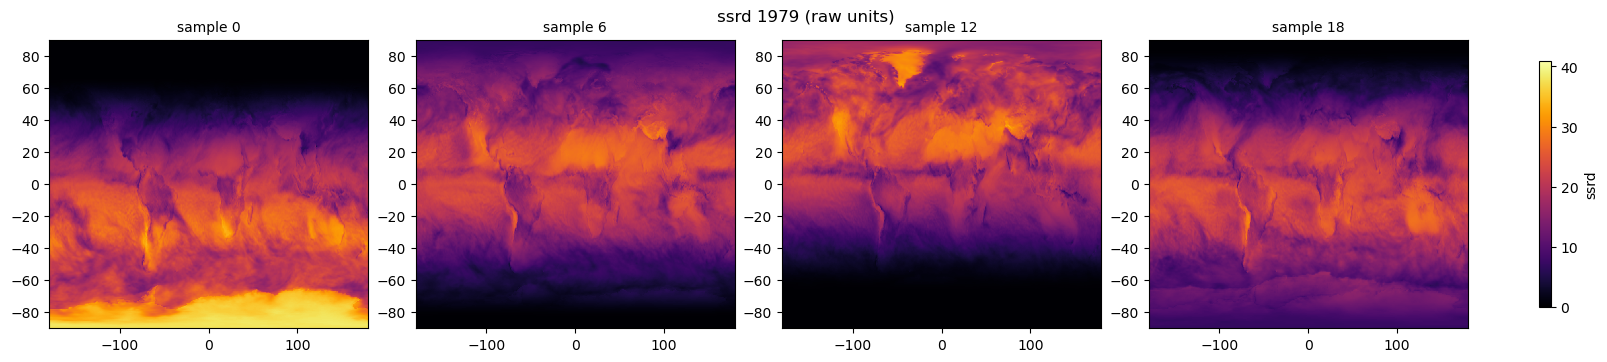

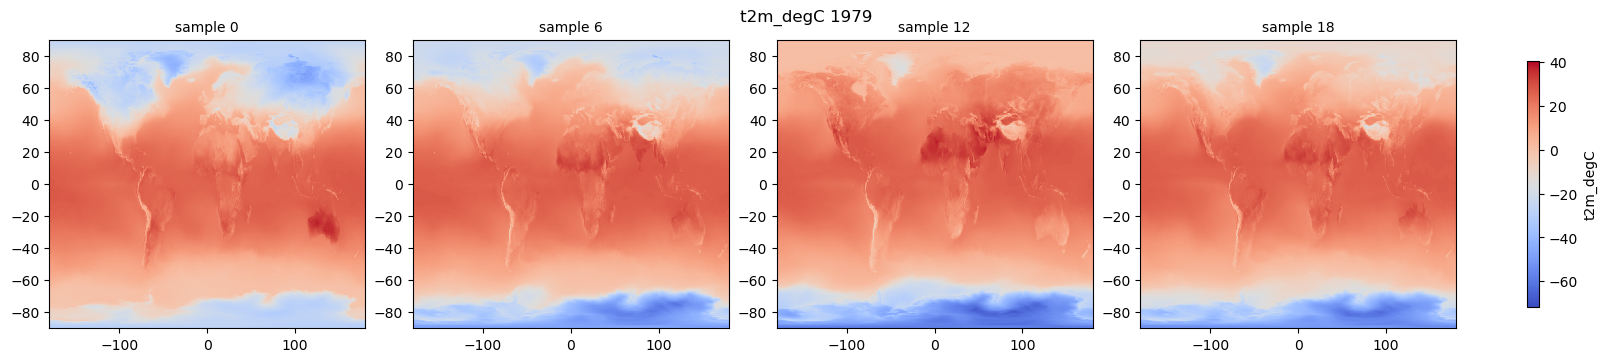

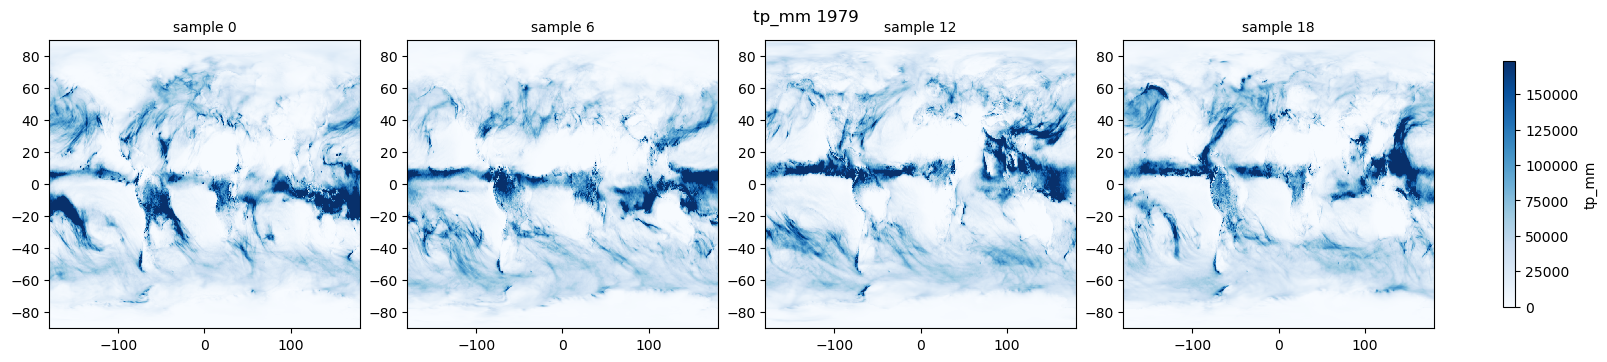

In [3]:
# Use variable units if you prefer raw; below I add readable conversions.

# A) SSRD (surface solar radiation downwards)
# Units in ERA5 are often J m-2 over the aggregation; we'll plot raw to avoid assumptions.
panel_4samples(ssrd, title=f"{ssrd_name} 1979 (raw units)", cmap="inferno")

# B) T2M (2m temperature) — convert K -> °C (most readable)
t2m_C = (t2m - 273.15).assign_attrs(units="°C")
t2m_C.name = f"{t2m_name}_degC"
panel_4samples(t2m_C, title=f"{t2m_C.name} 1979", cmap="coolwarm")

# C) TP (total precipitation) — convert m -> mm
tp_mm = (tp * 1000.0).assign_attrs(units="mm")
tp_mm.name = f"{tp_name}_mm"
# Precip fields can be very skewed; use robust limits from percentiles
p2, p98 = np.nanpercentile(tp_mm.values, [2,98])
panel_4samples(tp_mm, title=f"{tp_mm.name} 1979", cmap="Blues", vmin=0.0, vmax=p98)

In [ ]:
import os
import numpy as np
import xarray as xr

# ------------------- USER PARAMS -------------------
base_dir   = "/ptmp/mp002/ellis/lai"  # root for subfolders ssrd/, t2m/, tp/
vars_cfg = {
    "ssrd": {"subdir": "ssrd", "tmpl": "ssrd.15daily.fc.era5.1440.720.{year}.nc"},
    "t2m":  {"subdir": "t2m",  "tmpl": "t2m.15daily.an.era5.1440.720.{year}.nc"},
    "tp":   {"subdir": "tp",   "tmpl": "tp.15daily.fc.era5.1440.720.{year}.nc"},
}
years_all = range(1979, 2020)     # 1979..2019 inclusive
base_years = range(1982, 2018)    # climatology base (match your LAI); change to years_all if you prefer
engine = "netcdf4"

out_dir = "/ptmp/mp040/outputdir/era5/anom"   # where to save outputs
os.makedirs(out_dir, exist_ok=True)
# ---------------------------------------------------

def open_year_file(varname, year):
    subdir = vars_cfg[varname]["subdir"]
    tmpl   = vars_cfg[varname]["tmpl"]
    fp = os.path.join(base_dir, subdir, tmpl.format(year=year))
    ds = xr.open_dataset(fp, engine=engine)
    # Assume file contains the variable with the same name (ssrd/t2m/tp)
    da = ds[varname]
    # normalize missing
    fv = da.attrs.get("_FillValue", None)
    if fv is not None:
        da = da.where(da != fv)
    # orientation north-up
    lat_name = "lat" if "lat" in da.coords else "latitude"
    da = da.sortby(lat_name)
    # sanity: 24 samples
    if da.sizes.get("time", None) != 24:
        raise ValueError(f"{fp} has {da.sizes.get('time')} time steps; expected 24")
    # attach sample coord 0..23 (aligned to time)
    da = da.assign_coords(sample=("time", np.arange(da.sizes["time"])))
    return da

def compute_clim_mean_std(varname):
    """Pass 1: compute 24-sample climatology mean & std over base_years."""
    sum_arr = None
    sumsq_arr = None
    cnt_arr = None
    lat_name = lon_name = None

    for y in base_years:
        try:
            da = open_year_file(varname, y)  # dims: time, lat, lon; coord sample(time)
        except Exception as e:
            print(f"[WARN] {varname} {y}: {e}")
            continue

        # group to (sample, lat, lon)
        da24 = da.groupby("sample").mean("time", skipna=True)  # identity; just reshape

        # load to numpy (float32) for accumulation
        vals = da24.astype(np.float32).values  # shape (24, nlat, nlon)
        if sum_arr is None:
            sum_arr   = np.zeros_like(vals, dtype=np.float64)
            sumsq_arr = np.zeros_like(vals, dtype=np.float64)
            cnt_arr   = np.zeros_like(vals, dtype=np.int32)
            # coord names/values for wrapping back
            lat_name = "lat" if "lat" in da24.coords else "latitude"
            lon_name = "lon" if "lon" in da24.coords else "longitude"
            lat_vals = da24[lat_name].values
            lon_vals = da24[lon_name].values

        # NaN mask
        mask = np.isfinite(vals)
        # accumulate
        sum_arr[mask]   += vals[mask]
        sumsq_arr[mask] += vals[mask] * vals[mask]
        cnt_arr[mask]   += 1

    if sum_arr is None or cnt_arr.sum() == 0:
        raise RuntimeError(f"No valid years to compute climatology for {varname}")

    mean_arr = np.divide(sum_arr, cnt_arr, out=np.full_like(sum_arr, np.nan), where=cnt_arr>0)
    # unbiased variance (n-1); guard n<=1 → NaN
    var_arr = np.divide(sumsq_arr - (sum_arr * sum_arr) / np.maximum(cnt_arr, 1),
                        np.maximum(cnt_arr - 1, 0),
                        out=np.full_like(sum_arr, np.nan),
                        where=(cnt_arr - 1) > 0)
    std_arr = np.sqrt(var_arr, dtype=np.float64).astype(np.float32)

    # wrap back to DataArray (sample, lat, lon)
    coords = {"sample": np.arange(mean_arr.shape[0]), lat_name: lat_vals, lon_name: lon_vals}
    clim_mean = xr.DataArray(mean_arr.astype(np.float32), coords=coords, dims=["sample", lat_name, lon_name],
                             name=f"{varname}_climatology")
    clim_std  = xr.DataArray(std_arr, coords=coords, dims=["sample", lat_name, lon_name],
                             name=f"{varname}_climatology_std")
    clim_mean.attrs.update({
        "description": f"{varname} 24-sample climatology mean",
        "base_period": f"{base_years.start}-{base_years.stop-1}",
        "samples_per_year": 24,
    })
    clim_std.attrs.update({
        "description": f"{varname} 24-sample climatology std",
        "base_period": f"{base_years.start}-{base_years.stop-1}",
        "samples_per_year": 24,
    })

    # save climatology mean/std
    cm_path = os.path.join(out_dir, f"{varname}_climatology_mean_{base_years.start}_{base_years.stop-1}.nc")
    cs_path = os.path.join(out_dir, f"{varname}_climatology_std_{base_years.start}_{base_years.stop-1}.nc")
    clim_mean.to_dataset(name=clim_mean.name).to_netcdf(cm_path)
    clim_std.to_dataset(name=clim_std.name).to_netcdf(cs_path)
    print(f"[CLIM] {varname}: wrote\n  {cm_path}\n  {cs_path}")

    return clim_mean, clim_std

def write_year_anom_z(varname, clim_mean, clim_std):
    """Pass 2: per-year anomalies and z-scores, saved per year."""
    for y in years_all:
        try:
            da = open_year_file(varname, y)  # time + sample coord
        except Exception as e:
            print(f"[WARN] {varname} {y}: {e}")
            continue

        by_sample = da.groupby("sample")
        anom = by_sample - clim_mean
        z    = (by_sample - clim_mean) / clim_std

        # tidy names/attrs
        anom.name = f"{varname}_anom"
        z.name    = f"{varname}_z"
        base_str = f"{base_years.start}-{base_years.stop-1}"
        anom.attrs.update({
            "description": f"{varname} anomaly vs {base_str} 24-sample climatology",
            "base_period": base_str,
            "note": "sample=0..23 are half-month bins",
        })
        z.attrs.update({
            "description": f"{varname} z-score vs {base_str} 24-sample climatology",
            "base_period": base_str,
            "note": "z = (value - mean) / std; std NaNs where insufficient data",
        })

        out_anom = os.path.join(out_dir, f"{varname}_anom_{y}.nc")
        out_z    = os.path.join(out_dir, f"{varname}_z_{y}.nc")
        anom.to_dataset(name=anom.name).to_netcdf(out_anom)
        z.to_dataset(name=z.name).to_netcdf(out_z)
        print(f"[OK] {varname} {y}: wrote\n  {out_anom}\n  {out_z}")

# ------------------- RUN FOR ALL VARS -------------------
for varname in ("ssrd", "t2m", "tp"):
    print(f"\n=== {varname.upper()} : computing climatology over {base_years.start}-{base_years.stop-1} ===")
    clim_mean, clim_std = compute_clim_mean_std(varname)
    print(f"=== {varname.upper()} : writing per-year anomaly & z-score for {years_all.start}-{years_all.stop-1} ===")
    write_year_anom_z(varname, clim_mean, clim_std)

print("Done.")


=== SSRD : computing climatology over 1982-2017 ===
[CLIM] ssrd: wrote
  /ptmp/mp040/outputdir/anom_era5/anom/ssrd_climatology_mean_1982_2017.nc
  /ptmp/mp040/outputdir/anom_era5/anom/ssrd_climatology_std_1982_2017.nc
=== SSRD : writing per-year anomaly & z-score for 1979-2019 ===
[OK] ssrd 1979: wrote
  /ptmp/mp040/outputdir/anom_era5/anom/ssrd_anom_1979.nc
  /ptmp/mp040/outputdir/anom_era5/anom/ssrd_z_1979.nc
[OK] ssrd 1980: wrote
  /ptmp/mp040/outputdir/anom_era5/anom/ssrd_anom_1980.nc
  /ptmp/mp040/outputdir/anom_era5/anom/ssrd_z_1980.nc
[OK] ssrd 1981: wrote
  /ptmp/mp040/outputdir/anom_era5/anom/ssrd_anom_1981.nc
  /ptmp/mp040/outputdir/anom_era5/anom/ssrd_z_1981.nc
[OK] ssrd 1982: wrote
  /ptmp/mp040/outputdir/anom_era5/anom/ssrd_anom_1982.nc
  /ptmp/mp040/outputdir/anom_era5/anom/ssrd_z_1982.nc
[OK] ssrd 1983: wrote
  /ptmp/mp040/outputdir/anom_era5/anom/ssrd_anom_1983.nc
  /ptmp/mp040/outputdir/anom_era5/anom/ssrd_z_1983.nc
[OK] ssrd 1984: wrote
  /ptmp/mp040/outputdir/anom_e

KeyboardInterrupt: 

In [ ]:
import os, math
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# ------------------- USER PARAMS -------------------
base_dir   = "/ptmp/mp002/ellis/lai"  # root for subfolders ssrd/, t2m/, tp/
vars_cfg = {
    "ssrd": {"subdir": "ssrd", "tmpl": "ssrd.15daily.fc.era5.1440.720.{year}.nc"},
    "t2m":  {"subdir": "t2m",  "tmpl": "t2m.15daily.an.era5.1440.720.{year}.nc"},
    "tp":   {"subdir": "tp",   "tmpl": "tp.15daily.fc.era5.1440.720.{year}.nc"},
}
years_all  = range(1979, 2020)     # 1979..2019 inclusive
base_years = range(1982, 2018)     # climatology base
engine     = "netcdf4"

out_dir_anom = "/ptmp/mp040/outputdir/era5/anom"
out_dir_clim = "/ptmp/mp040/outputdir/era5/clim"
png_dpi = 160
os.makedirs(out_dir_anom, exist_ok=True)
os.makedirs(out_dir_clim, exist_ok=True)
# ---------------------------------------------------

def open_year_file(varname, year):
    subdir = vars_cfg[varname]["subdir"]
    tmpl   = vars_cfg[varname]["tmpl"]
    fp = os.path.join(base_dir, subdir, tmpl.format(year=year))
    ds = xr.open_dataset(fp, engine=engine)
    da = ds[varname]
    # normalize missing
    fv = da.attrs.get("_FillValue", None)
    if fv is not None:
        da = da.where(da != fv)
    # orientation north-up
    lat_name = "lat" if "lat" in da.coords else "latitude"
    da = da.sortby(lat_name)
    # sanity: 24 samples
    if da.sizes.get("time", None) != 24:
        raise ValueError(f"{fp} has {da.sizes.get('time')} time steps; expected 24")
    # attach sample coord 0..23
    da = da.assign_coords(sample=("time", np.arange(da.sizes["time"])))
    return da

def compute_clim_mean_std(varname):
    """Pass 1: compute 24-sample climatology mean & std over base_years."""
    sum_arr = sumsq_arr = cnt_arr = None
    lat_name = lon_name = None

    for y in base_years:
        try:
            da = open_year_file(varname, y)
        except Exception as e:
            print(f"[WARN] {varname} {y}: {e}")
            continue

        da24 = da.groupby("sample").mean("time", skipna=True)
        vals = da24.astype(np.float32).values  # (24, nlat, nlon)

        if sum_arr is None:
            sum_arr   = np.zeros_like(vals, dtype=np.float64)
            sumsq_arr = np.zeros_like(vals, dtype=np.float64)
            cnt_arr   = np.zeros_like(vals, dtype=np.int32)
            lat_name = "lat" if "lat" in da24.coords else "latitude"
            lon_name = "lon" if "lon" in da24.coords else "longitude"
            lat_vals = da24[lat_name].values
            lon_vals = da24[lon_name].values

        mask = np.isfinite(vals)
        sum_arr[mask]   += vals[mask]
        sumsq_arr[mask] += vals[mask] * vals[mask]
        cnt_arr[mask]   += 1

    if sum_arr is None or cnt_arr.sum() == 0:
        raise RuntimeError(f"No valid years to compute climatology for {varname}")

    mean_arr = np.divide(sum_arr, cnt_arr, out=np.full_like(sum_arr, np.nan), where=cnt_arr>0)
    var_arr  = np.divide(
        sumsq_arr - (sum_arr * sum_arr) / np.maximum(cnt_arr, 1),
        np.maximum(cnt_arr - 1, 0),
        out=np.full_like(sum_arr, np.nan),
        where=(cnt_arr - 1) > 0,
    )
    std_arr = np.sqrt(var_arr, dtype=np.float64).astype(np.float32)

    coords = {"sample": np.arange(mean_arr.shape[0]), lat_name: lat_vals, lon_name: lon_vals}
    clim_mean = xr.DataArray(mean_arr.astype(np.float32), coords=coords, dims=["sample", lat_name, lon_name],
                             name=f"{varname}_climatology")
    clim_std  = xr.DataArray(std_arr, coords=coords, dims=["sample", lat_name, lon_name],
                             name=f"{varname}_climatology_std")

    base_str = f"{base_years.start}-{base_years.stop-1}"
    clim_mean.attrs.update({"description": f"{varname} 24-sample climatology mean", "base_period": base_str})
    clim_std.attrs.update({"description": f"{varname} 24-sample climatology std",  "base_period": base_str})

    cm_path = os.path.join(out_dir_clim, f"{varname}_climatology_mean_{base_years.start}_{base_years.stop-1}.nc")
    cs_path = os.path.join(out_dir_clim, f"{varname}_climatology_std_{base_years.start}_{base_years.stop-1}.nc")
    clim_mean.to_dataset(name=clim_mean.name).to_netcdf(cm_path)
    clim_std.to_dataset(name=clim_std.name).to_netcdf(cs_path)
    print(f"[CLIM] {varname}: wrote\n  {cm_path}\n  {cs_path}")

    return clim_mean, clim_std, lat_name

# ---------- plotting helper ----------
def plot_24_panel(da24, title, out_png, vmin=None, vmax=None, cmap=None, yincrease=True):
    n = da24.sizes["sample"]
    ncols, nrows = 6, math.ceil(n / 6)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3.0, nrows*2.6), constrained_layout=True)
    axes = axes.ravel()

    if vmin is None or vmax is None:
        vmin = float(da24.min().values)
        vmax = float(da24.max().values)

    mappable = None
    for i in range(n):
        ax = axes[i]
        img = da24.isel(sample=i).plot(ax=ax, add_colorbar=False, vmin=vmin, vmax=vmax,
                                       cmap=cmap, yincrease=yincrease)
        if mappable is None:
            mappable = img
        ax.set_title(f"S{i:02d}", fontsize=9)
        ax.set_xlabel(""); ax.set_ylabel("")
    for j in range(n, len(axes)):
        axes[j].axis("off")

    cbar = fig.colorbar(mappable, ax=axes.tolist(), shrink=0.85)
    cbar.set_label(da24.name if da24.name else "")
    plt.suptitle(title, y=1.02)
    plt.savefig(out_png, dpi=png_dpi, bbox_inches="tight")
    plt.close(fig)
    print(f"[PNG] {out_png}")

def write_year_anom_z(varname, clim_mean, clim_std, lat_name):
    """Pass 2: per-year anomalies and z-scores, saved per year + PNGs."""
    base_str = f"{base_years.start}-{base_years.stop-1}"
    for y in years_all:
        try:
            da = open_year_file(varname, y)
        except Exception as e:
            print(f"[WARN] {varname} {y}: {e}")
            continue

        by_sample = da.groupby("sample")
        anom = by_sample - clim_mean
        z    = (by_sample - clim_mean) / clim_std

        anom.name = f"{varname}_anom"
        z.name    = f"{varname}_z"

        anom.attrs.update({"description": f"{varname} anomaly vs {base_str}", "base_period": base_str})
        z.attrs.update({"description": f"{varname} z-score vs {base_str}", "base_period": base_str})

        # Save NetCDFs
        out_anom_nc = os.path.join(out_dir_anom, f"{varname}_anom_{y}.nc")
        out_z_nc    = os.path.join(out_dir_anom, f"{varname}_z_{y}.nc")
        anom.to_dataset(name=anom.name).to_netcdf(out_anom_nc)
        z.to_dataset(name=z.name).to_netcdf(out_z_nc)
        print(f"[OK] {varname} {y}: wrote\n  {out_anom_nc}\n  {out_z_nc}")

        # PNGs
        anom24 = anom.groupby("sample").mean("time")
        z24    = z.groupby("sample").mean("time")

        a2, a98 = np.nanpercentile(anom24.values, [2, 98])
        a_abs   = max(abs(a2), abs(a98))
        a_vmin, a_vmax = -a_abs, a_abs
        z_vmin, z_vmax = -3.0, 3.0

        plot_24_panel(anom24, f"{varname.upper()} anomaly {y} (vs {base_str})",
                      os.path.join(out_dir_anom, f"{varname}_anom_{y}.png"),
                      vmin=a_vmin, vmax=a_vmax, cmap="RdBu_r", yincrease=True)

        plot_24_panel(z24, f"{varname.upper()} z-score {y} (vs {base_str})",
                      os.path.join(out_dir_anom, f"{varname}_z_{y}.png"),
                      vmin=z_vmin, vmax=z_vmax, cmap="RdYlBu_r", yincrease=True)

# ------------------- RUN -------------------
for varname in ("ssrd", "t2m", "tp"):
    print(f"\n=== {varname.upper()} climatology {base_years.start}-{base_years.stop-1} ===")
    clim_mean, clim_std, lat_name = compute_clim_mean_std(varname)
    print(f"=== {varname.upper()} anomalies & z-scores {years_all.start}-{years_all.stop-1} ===")
    write_year_anom_z(varname, clim_mean, clim_std, lat_name)

print("Done.")